# Creating a grid

## The Grid object

In [1]:
from roms_tools import Grid

We can create a ROMS grid, mask, topography, and vertical coordinate system by creating an instance of the `Grid` class.

In [2]:
%%time

grid = Grid(
    nx=100,  # number of points in the x-direction (excluding 2 boundary cells)
    ny=100,  # number of points in the y-direction (excluding 2 boundary cells)
    size_x=1800,  # size of the domain in the x-direction (in km)
    size_y=2400,  # size of the domain in the y-direction (in km)
    center_lon=-10,  # longitude of the center of the domain
    center_lat=61,  # latitude of the center of the domain
    rot=20,  # rotation of the grid (positive is counter-clockwise)
    verbose=True,  # default is False
)

INFO - === Creating the horizontal grid ===
INFO - Total time: 0.033 seconds
INFO - ========================================================================================================
INFO - === Generating the topography and mask using ETOPO5 data and hmin = 5.0 meters ===
INFO - Reading the topography data: 1.010 seconds
INFO - Concatenating the data along the longitude dimension: 0.875 seconds
INFO - Regridding the topography: 0.004 seconds
INFO - Preparing the masks: 0.003 seconds
INFO - Smoothing the topography globally: 0.005 seconds
INFO - Smoothing the topography locally: 1.457 seconds
INFO - Total time: 3.381 seconds
INFO - ========================================================================================================
INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
INFO - Total time: 0.003 seconds
INFO - ==================================================================================================

CPU times: user 1.62 s, sys: 161 ms, total: 1.78 s
Wall time: 4.71 s


We generated the grid with verbose mode enabled, allowing us to see which steps were taken and how long each took. As you can see from the printed output, the three main steps are as follows:

I. [Creating the horizontal grid](https://roms-tools.readthedocs.io/en/latest/methods.html#horizontal-grid)

II. [Generating the topography and mask](https://roms-tools.readthedocs.io/en/latest/methods.html#topography-and-mask)

III. [Preparing the vertical coordinate system](https://roms-tools.readthedocs.io/en/latest/methods.html#vertical-coordinate-system)

We will explore steps II. and III. in more detail later. For now, let's examine the grid variables that were created, which can be found in the `xarray.Dataset` object returned by the `.ds` property.

In [3]:
grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:       (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                   eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 83kB 47.84 47.91 ... 73.51 73.53
    lon_rho       (eta_rho, xi_rho) float64 83kB 344.0 344.3 ... 3.644 4.207
    lat_u         (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.5 73.52
    lon_u         (eta_rho, xi_u) float64 82kB 344.2 344.4 344.6 ... 3.362 3.925
    lat_v         (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.4 73.42
    lon_v         (eta_v, xi_rho) float64 82kB 344.0 344.2 344.4 ... 3.687 4.247
    lat_coarse    (eta_coarse, xi_coarse) float64 22kB 47.71 47.84 ... 73.64
    lon_coarse    (eta_coarse, xi_coarse) float64 22kB 344.0 344.4 ... 4.451
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146 0.1146
    f             (eta_rho, xi_rho) float64 83kB 0.0001078 ... 0.0001395
    pm            (eta_rho, xi_rho) float64 83kB 4.209e-05 ... 4.209e-05
    pn            (eta_rho, xi_rho) float64 83kB 5.592e-05 ... 5.592e-05
    spherical     |S1 1B b'T'
    mask_rho      (eta_rho, xi_rho) int32 42kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ...            ...
    angle_coarse  (eta_coarse, xi_coarse) float64 22kB 0.4166 0.4151 ... 0.1151
    mask_coarse   (eta_coarse, xi_coarse) int32 11kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    sigma_r       (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r          (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    sigma_w       (s_w) float32 404B -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    Cs_w          (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev138+dirty
    size_x:              1800
    size_y:              2400
    center_lon:          -10
    center_lat:          61
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

To visualize the grid we have just created, we can use the `.plot` method.

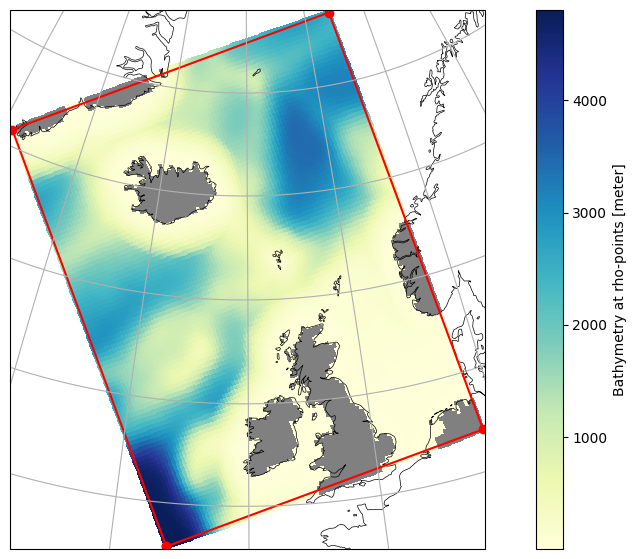

In [4]:
grid.plot(bathymetry=True)

### Saving as NetCDF or YAML file

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [5]:
filepath = "/pscratch/sd/n/nloose/grids/my_roms_grid.nc"

In [6]:
grid.save(filepath)

[PosixPath('/pscratch/sd/n/nloose/grids/my_roms_grid.nc')]

We can also export the grid parameters to a YAML file. This gives us a more storage-effective way to save and share input data made with `ROMS-Tools`. The YAML file can be used to recreate the same grid object later.

In [7]:
yaml_filepath = "/pscratch/sd/n/nloose/grids/my_roms_grid.yaml"

In [8]:
grid.to_yaml(yaml_filepath)

These are the contents of the written YAML file.

In [9]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev138+dirty
---
Grid:
  nx: 100
  ny: 100
  size_x: 1800
  size_y: 2400
  center_lon: -10
  center_lat: 61
  rot: 20
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: ETOPO5
  hmin: 5.0



### Creating a grid from an existing NetCDF or YAML file

We can also create a grid from an existing file.

In [10]:
filepath = "/pscratch/sd/n/nloose/grids/my_roms_grid.nc"

In [11]:
the_same_grid = Grid.from_file(filepath)

In [12]:
the_same_grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:       (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                   eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 83kB ...
    lon_rho       (eta_rho, xi_rho) float64 83kB ...
    lat_u         (eta_rho, xi_u) float64 82kB ...
    lon_u         (eta_rho, xi_u) float64 82kB ...
    lat_v         (eta_v, xi_rho) float64 82kB ...
    lon_v         (eta_v, xi_rho) float64 82kB ...
    lat_coarse    (eta_coarse, xi_coarse) float64 22kB ...
    lon_coarse    (eta_coarse, xi_coarse) float64 22kB ...
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 83kB ...
    f             (eta_rho, xi_rho) float64 83kB ...
    pm            (eta_rho, xi_rho) float64 83kB ...
    pn            (eta_rho, xi_rho) float64 83kB ...
    spherical     |S1 1B ...
    mask_rho      (eta_rho, xi_rho) int32 42kB ...
    ...            ...
    angle_coarse  (eta_coarse, xi_coarse) float64 22kB ...
    mask_coarse   (eta_coarse, xi_coarse) int32 11kB ...
    sigma_r       (s_rho) float32 400B ...
    Cs_r          (s_rho) float32 400B ...
    sigma_w       (s_w) float32 404B ...
    Cs_w          (s_w) float32 404B ...
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev138+dirty
    size_x:              1800
    size_y:              2400
    center_lon:          -10
    center_lat:          61
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

Alternatively, we can create a grid from an existing YAML file.

In [13]:
yaml_filepath = "/pscratch/sd/n/nloose/grids/my_roms_grid.yaml"

In [14]:
%time yet_the_same_grid = Grid.from_yaml(yaml_filepath, verbose=False)

CPU times: user 1.51 s, sys: 12.5 ms, total: 1.52 s
Wall time: 2.28 s


In [15]:
yet_the_same_grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:       (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                   eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 83kB 47.84 47.91 ... 73.51 73.53
    lon_rho       (eta_rho, xi_rho) float64 83kB 344.0 344.3 ... 3.644 4.207
    lat_u         (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.5 73.52
    lon_u         (eta_rho, xi_u) float64 82kB 344.2 344.4 344.6 ... 3.362 3.925
    lat_v         (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.4 73.42
    lon_v         (eta_v, xi_rho) float64 82kB 344.0 344.2 344.4 ... 3.687 4.247
    lat_coarse    (eta_coarse, xi_coarse) float64 22kB 47.71 47.84 ... 73.64
    lon_coarse    (eta_coarse, xi_coarse) float64 22kB 344.0 344.4 ... 4.451
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146 0.1146
    f             (eta_rho, xi_rho) float64 83kB 0.0001078 ... 0.0001395
    pm            (eta_rho, xi_rho) float64 83kB 4.209e-05 ... 4.209e-05
    pn            (eta_rho, xi_rho) float64 83kB 5.592e-05 ... 5.592e-05
    spherical     |S1 1B b'T'
    mask_rho      (eta_rho, xi_rho) int32 42kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ...            ...
    angle_coarse  (eta_coarse, xi_coarse) float64 22kB 0.4166 0.4151 ... 0.1151
    mask_coarse   (eta_coarse, xi_coarse) int32 11kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    sigma_r       (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r          (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    sigma_w       (s_w) float32 404B -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    Cs_w          (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev138+dirty
    size_x:              1800
    size_y:              2400
    center_lon:          -10
    center_lat:          61
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

## Topography and Mask

[Here](https://roms-tools.readthedocs.io/en/latest/methods.html#topography-and-mask) you can find an overview of the steps involved in the topography and mask generation. In the following, we will illustrate how these concepts work in practice.

### Topography source data

The grid object includes a parameter called `topography_source`. If this parameter is not specified, it defaults to using the ETOPO5 topography data. The ETOPO5 data is downloaded internally, so the user does not need to provide a filename. 

The ETOPO5 data has a horizontal resolution of 5 arc-minutes (or 1/12th of a degree). This horizontal resolution was sufficient for the coarse-resolution grid that we generated above, but for finer-resolution grids we might want to use finer-resolution topography products such as SRTM15. SRTM15 has a horizontal resolution of 15 arc-seconds (or 1/240th of a degree). 

Let's compare the topographies that are generated from ETOPO5 versus SRTM15 data for a ROMS grid surrounding Iceland.

In [16]:
iceland_kwargs = {
    "size_x": 800,
    "size_y": 800,
    "center_lon": -19,
    "center_lat": 65,
    "rot": 20,
}

First, we generate two coarse-resolution grids with 100 x 100 grid points: one regridded from the ETOPO5 data and the other from the SRTM15 data.

In [17]:
%%time

coarse_grid_ETOPO5 = Grid(nx=100, ny=100, **iceland_kwargs, verbose=False)

CPU times: user 1.15 s, sys: 27.7 ms, total: 1.18 s
Wall time: 1.35 s


In [18]:
%%time

coarse_grid_SRTM15 = Grid(
    nx=100,
    ny=100,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
    **iceland_kwargs,
    verbose=False
)

CPU times: user 1.35 s, sys: 31.7 ms, total: 1.38 s
Wall time: 2.25 s


Comparing the timings above, we can see that generating the topographies took a similar amount of time and was quick overall. Next, let’s compare the generated topography fields.

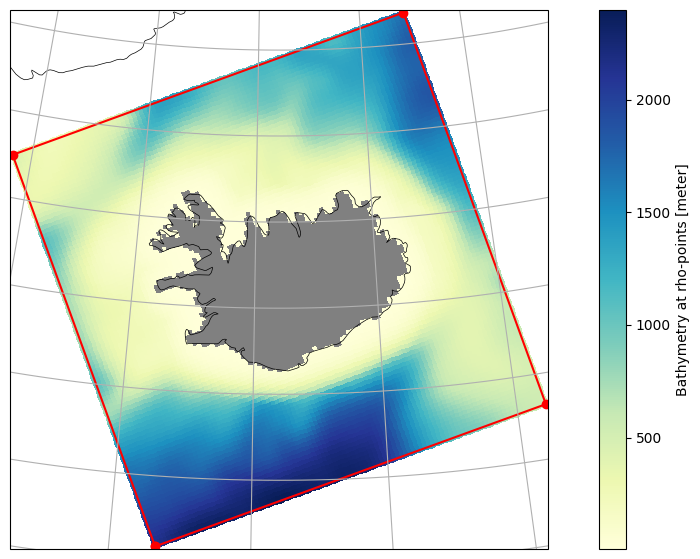

In [19]:
coarse_grid_ETOPO5.plot(bathymetry=True)

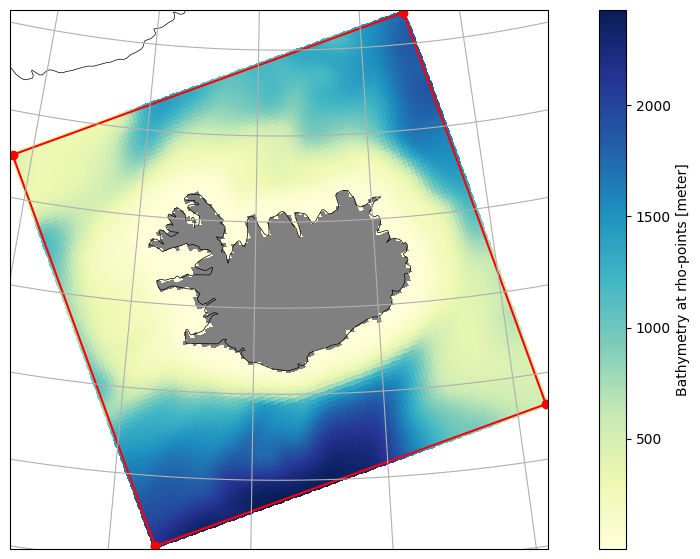

In [20]:
coarse_grid_SRTM15.plot(bathymetry=True)

Comparing the figures above, we don’t see significant differences in the generated topography fields. The grid is simply too coarse to fully utilize the high-resolution SRTM15 data. The mask generated with the SRTM15 data does appear to fill in the land outlined by the Cartopy coastlines slightly better. However, to observe more noticeable differences, we need to use a finer resolution grid.

Let's do that! Next, we generate two fine-resolution grids with 5000 x 5000 grid points: one regridded from the ETOPO5 data and the other from the SRTM15 data.

In [21]:
%%time

fine_grid = Grid(nx=5000, ny=5000, **iceland_kwargs, verbose=True)

INFO - === Creating the horizontal grid ===
INFO - Total time: 37.808 seconds
INFO - ========================================================================================================
INFO - === Generating the topography and mask using ETOPO5 data and hmin = 5.0 meters ===
INFO - Reading the topography data: 0.279 seconds
INFO - Regridding the topography: 1.129 seconds
INFO - Preparing the masks: 1.442 seconds
INFO - Smoothing the topography globally: 6.645 seconds
INFO - Smoothing the topography locally: 83.549 seconds
INFO - Total time: 93.146 seconds
INFO - ========================================================================================================
INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
INFO - Total time: 0.003 seconds
INFO - ========================================================================================================


CPU times: user 1min 27s, sys: 43.4 s, total: 2min 11s
Wall time: 2min 11s


In [22]:
%%time

fine_grid_SRTM15 = Grid(
    nx=5000,
    ny=5000,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
    **iceland_kwargs,
    verbose=True
)

INFO - === Creating the horizontal grid ===
INFO - Total time: 37.805 seconds
INFO - ========================================================================================================
INFO - === Generating the topography and mask using SRTM15 data and hmin = 5.0 meters ===
INFO - Reading the topography data: 0.518 seconds
INFO - Regridding the topography: 2.770 seconds
INFO - Preparing the masks: 8.036 seconds
INFO - Smoothing the topography globally: 6.547 seconds
INFO - Smoothing the topography locally: 97.864 seconds
INFO - Total time: 115.840 seconds
INFO - ========================================================================================================
INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
INFO - Total time: 0.003 seconds
INFO - ========================================================================================================


CPU times: user 1min 47s, sys: 45.7 s, total: 2min 33s
Wall time: 2min 34s


This time, generating the grids and topographies took longer, but the durations were again similar for both cases. The SRTM15 topography took slightly longer to process, particularly during the local smoothing phase. The goal of this smoothing is to ensure that the local steepness ratio does not exceed the threshold of 0.2. Because the SRTM15 data contains more details, it required more iterations for smoothing. Overall, the performance was still quite acceptable!

Let's take a look at the generated topography fields.

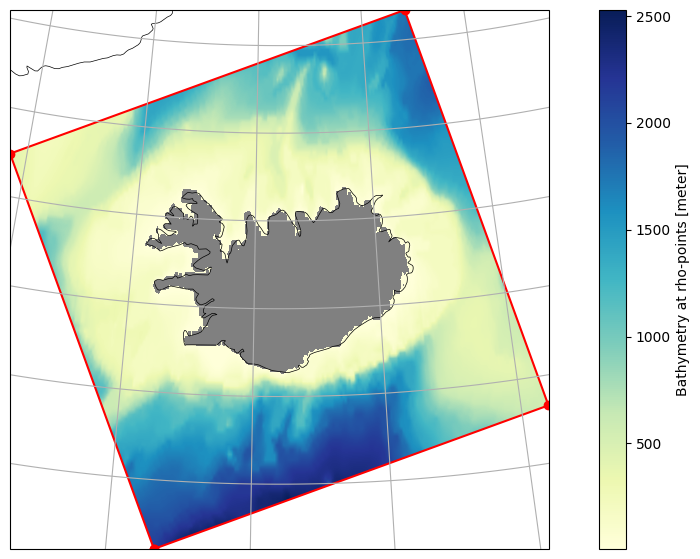

In [23]:
fine_grid.plot(bathymetry=True)  # grid with ETOPO5 topography

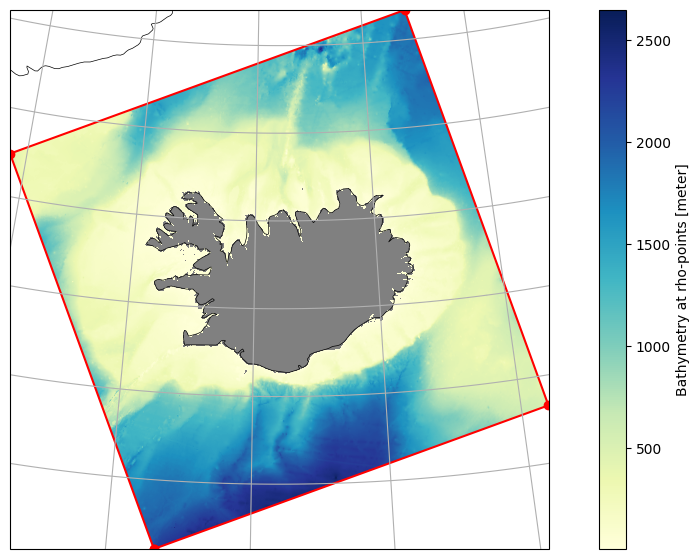

In [24]:
fine_grid_SRTM15.plot(bathymetry=True)  # grid with SRTM15 topography

The two figures above reveal differences: the topography and mask generated with the SRTM15 data show a lot more detail. If we move to an even finer resolution, these differences will become even more pronounced.

### The minimal ocean depth `hmin`

The default for `hmin` is 5 meters. In the above examples, we did not specify the (optional) `hmin` parameter, so it was set to the default value.

In [25]:
fine_grid.hmin

5.0

Let's confirm that the minimum ocean depth is indeed at least 5 meters.

In [26]:
fine_grid.ds["h"].min()

<xarray.DataArray 'h' ()> Size: 8B
array(5.)

We can define a grid with a different `hmin`.

In [27]:
%%time

fine_grid_with_larger_hmin = Grid(
    nx=5000,
    ny=5000,
    **iceland_kwargs,
    verbose=True,
    hmin=10.0,  # Minimum ocean depth in meters (default: 5.0)
)

INFO - === Creating the horizontal grid ===
INFO - Total time: 38.254 seconds
INFO - ========================================================================================================
INFO - === Generating the topography and mask using ETOPO5 data and hmin = 10.0 meters ===
INFO - Reading the topography data: 0.301 seconds
INFO - Regridding the topography: 0.932 seconds
INFO - Preparing the masks: 1.449 seconds
INFO - Smoothing the topography globally: 6.595 seconds
INFO - Smoothing the topography locally: 40.974 seconds
INFO - Total time: 50.354 seconds
INFO - ========================================================================================================
INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
INFO - Total time: 0.003 seconds
INFO - ========================================================================================================


CPU times: user 1min 4s, sys: 24.9 s, total: 1min 29s
Wall time: 1min 29s


In [28]:
fine_grid_with_larger_hmin.ds["h"].min()

<xarray.DataArray 'h' ()> Size: 8B
array(10.)

### Updating topography, mask, and `hmin`

When working with a grid that has a large number of grid points, such as `nx` = `ny` = 5000 in the example above, Step I (creating the horizontal grid) can be quite time-consuming: it took around 40 seconds! If you simply want to repeat Step II, which involves updating the topography, mask, and/or `hmin`, but you would like to keep the same horizontal grid, you can skip Step I. This can be easily achieved using the `.update_topography_and_mask` method. In the next cell, we take our fine resolution grid with ETOPO5 topography, and update it with SRTM15 topography and a larger `hmin` of 10 meters.

In [29]:
%%time

fine_grid.update_topography_and_mask(
    hmin=10.0,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
    verbose=True,
)

INFO - === Generating the topography and mask using SRTM15 data and hmin = 10.0 meters ===
INFO - Reading the topography data: 0.156 seconds
INFO - Regridding the topography: 2.794 seconds
INFO - Preparing the masks: 8.438 seconds
INFO - Smoothing the topography globally: 6.759 seconds
INFO - Smoothing the topography locally: 57.511 seconds
INFO - Total time: 75.771 seconds
INFO - ========================================================================================================


CPU times: user 50.2 s, sys: 25.8 s, total: 1min 15s
Wall time: 1min 16s


From the printed output, you can see that Steps I and III were skipped as desired. The following confirms that the `topography_source` and `hmin` were indeed updated.

In [30]:
fine_grid

Grid(nx=5000, ny=5000, size_x=800, size_y=800, center_lon=-19, center_lat=65, rot=20, N=100, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'SRTM15', 'path': '/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc'}, hmin=10.0, verbose=True, straddle=False)

## The vertical coordinate system

[Here](https://roms-tools.readthedocs.io/en/latest/methods.html#vertical-coordinate-system) you can find an overview of the steps involved in creating the vertical coordinate system.

To prepare the vertical coordinate system, `ROMS-Tools` needs the following parameters:

* `N`: the number of vertical layers (default: 100)
* `theta_s`: the surface control parameter (default: 5.0)
* `theta_b`: the bottom control parameter (default: 2.0)
* `hc`: the critical depth in meters (default: 300.0)

In the above examples, we did not specify any of these (optional) four parameters, so they were set to the default values.

In [16]:
grid

Grid(nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-10, center_lat=61, rot=20, N=100, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=True, straddle=True)

In [17]:
print(f"N: {grid.N}, theta_s: {grid.theta_s}, theta_b: {grid.theta_b}, hc: {grid.hc}")

N: 100, theta_s: 5.0, theta_b: 2.0, hc: 300.0


Among the [steps involved in generating the vertical coordinate system](https://roms-tools.readthedocs.io/en/latest/methods.html#vertical-coordinate-system), only the first two are executed during grid generation. 
Specifically, the `grid.ds` object contains the vertical stretched coordinates (`sigma_r` and `sigma_w`), as well as the vertical stretching functions (`Cs_r` and `Cs_w`).

In [18]:
grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:       (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101,
                   eta_coarse: 52, xi_coarse: 52, s_rho: 100, s_w: 101)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 83kB 47.84 47.91 ... 73.51 73.53
    lon_rho       (eta_rho, xi_rho) float64 83kB 344.0 344.3 ... 3.644 4.207
    lat_u         (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.5 73.52
    lon_u         (eta_rho, xi_u) float64 82kB 344.2 344.4 344.6 ... 3.362 3.925
    lat_v         (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.4 73.42
    lon_v         (eta_v, xi_rho) float64 82kB 344.0 344.2 344.4 ... 3.687 4.247
    lat_coarse    (eta_coarse, xi_coarse) float64 22kB 47.71 47.84 ... 73.64
    lon_coarse    (eta_coarse, xi_coarse) float64 22kB 344.0 344.4 ... 4.451
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146 0.1146
    f             (eta_rho, xi_rho) float64 83kB 0.0001078 ... 0.0001395
    pm            (eta_rho, xi_rho) float64 83kB 4.209e-05 ... 4.209e-05
    pn            (eta_rho, xi_rho) float64 83kB 5.592e-05 ... 5.592e-05
    spherical     |S1 1B b'T'
    mask_rho      (eta_rho, xi_rho) int32 42kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ...            ...
    angle_coarse  (eta_coarse, xi_coarse) float64 22kB 0.4166 0.4151 ... 0.1151
    mask_coarse   (eta_coarse, xi_coarse) int32 11kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    sigma_r       (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r          (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    sigma_w       (s_w) float32 404B -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    Cs_w          (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev138+dirty
    size_x:              1800
    size_y:              2400
    center_lon:          -10
    center_lat:          61
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

Text(0.5, 1.0, 'Vertical stretching function at rho-points')

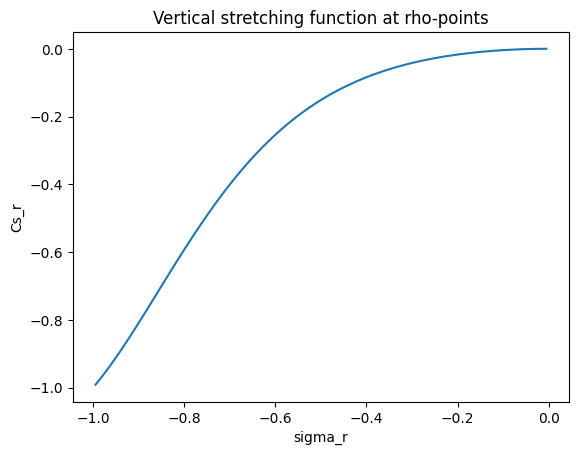

In [19]:
import matplotlib.pyplot as plt

plt.plot(grid.ds.sigma_r, grid.ds.Cs_r)
plt.xlabel("sigma_r")
plt.ylabel("Cs_r")
plt.title("Vertical stretching function at rho-points")

The vertical stretching functions, along with the topography, are used to compute the depth of the layers and interfaces, as described in step 3 of [this list](https://roms-tools.readthedocs.io/en/latest/methods.html#vertical-coordinate-system). Since this step can be computationally expensive and memory-intensive for large grids (e.g., `nx` = `ny` = 5000 as in one of the examples above), `ROMS-Tools` does not compute the layer depths and interfaces during grid generation. Instead, they are calculated later, when needed for generating initial conditions or boundary forcing.

However, if you wish to visualize the layer depths during the grid generation, they can be computed and plotted as demonstrated in the next section.

### Plotting the vertical coordinate system

You can visualize the vertical coordinate system from different perspectives using the `.plot_vertical_coordinate` method. Let's begin by examining the depth of the different layers.

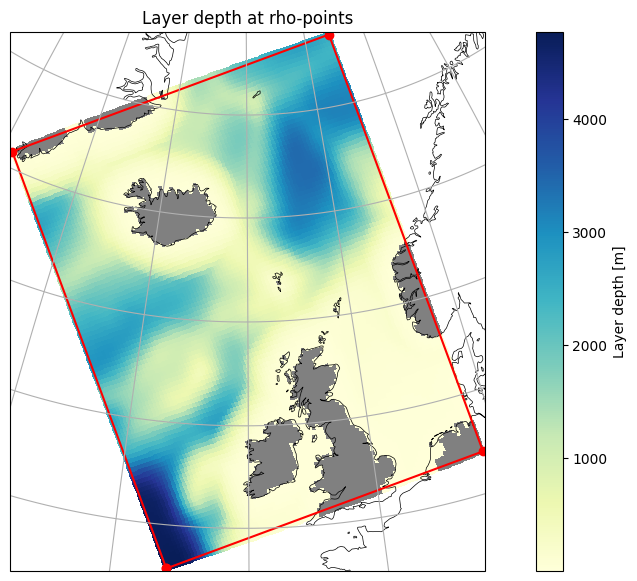

In [20]:
grid.plot_vertical_coordinate(s=0)  # depth of the lowermost layer at rho-points

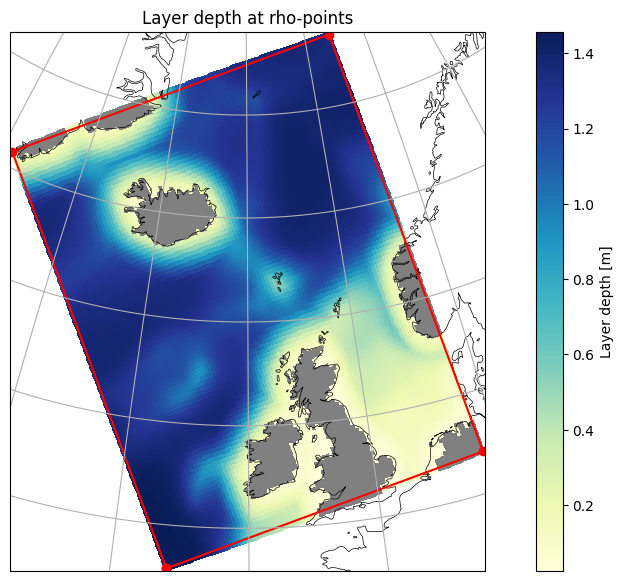

In [21]:
grid.plot_vertical_coordinate(s=-1)  # depth of the uppermost layer at rho-points

We are now interested in a vertical view of our layers. We can look at a transect by slicing through the `eta` or `xi` dimensions.

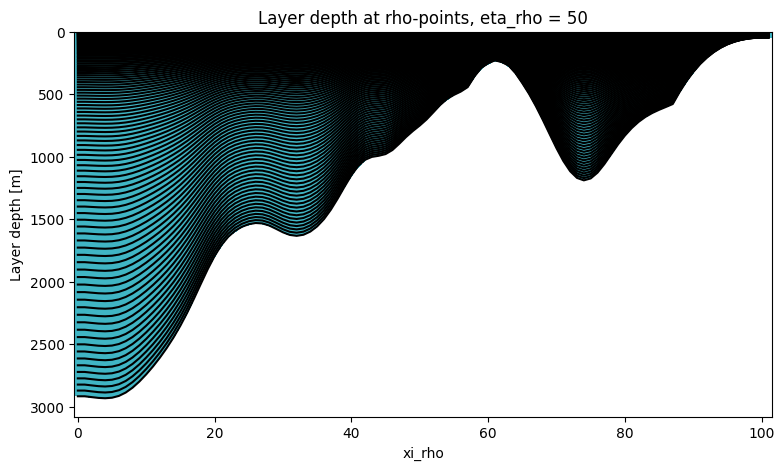

In [22]:
grid.plot_vertical_coordinate(eta=50)

The upper ocean layers are so densely packed that the lines converge and become indistinguishable. 

### Vertical coordinate system parameters

To investigate the vertical coordinate system parameters, we start with a control grid.

In [23]:
fixed_grid_parameters = {
    "nx": 100,
    "ny": 100,
    "size_x": 1800,
    "size_y": 2400,
    "center_lon": -21,
    "center_lat": 61,
    "rot": 20,
    "N": 20,
}

In [24]:
control_grid = Grid(
    **fixed_grid_parameters,
    theta_s=5.0,
    theta_b=2.0,
    hc=300.0,
)

In [25]:
control_grid

Grid(nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20, N=20, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=False, straddle=False)

We will now change the vertical coordinate system parameters `theta_s`, `theta_b`, and `hc`, and see what effect this has.

#### Critical depth

The critical depth `hc` sets the transition between flat $z$-levels in the upper ocean and terrain-following sigma-levels below. Usually we want to choose `hc` to be comparable with the expected depth of the pycnocline. That being said, let's experiment with the `hc` parameter. 

In [26]:
grid_with_large_critical_depth = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=control_grid.theta_b,
    hc=1000.0,
)

grid_with_small_critical_depth = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=control_grid.theta_b,
    hc=50.0,
)

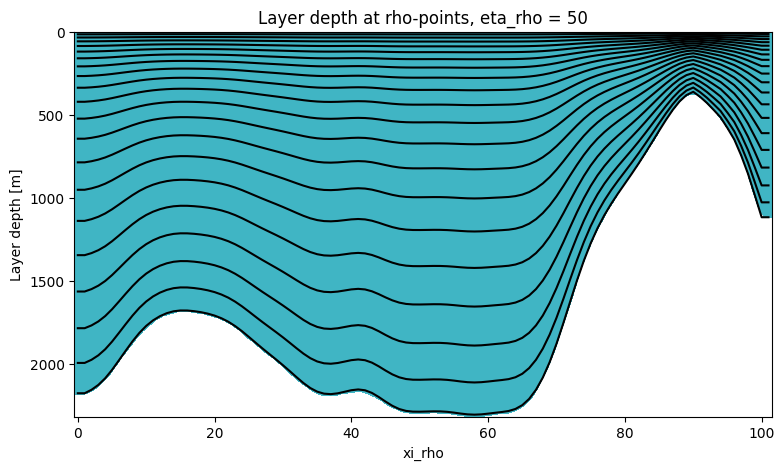

In [27]:
control_grid.plot_vertical_coordinate(eta=50)

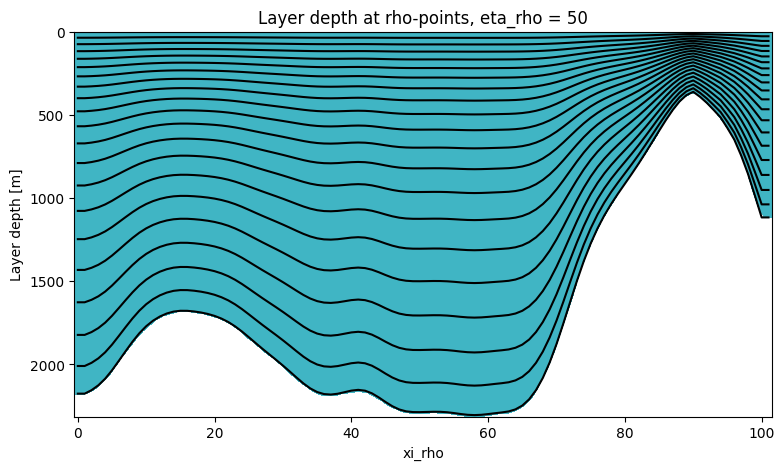

In [28]:
grid_with_large_critical_depth.plot_vertical_coordinate(eta=50)

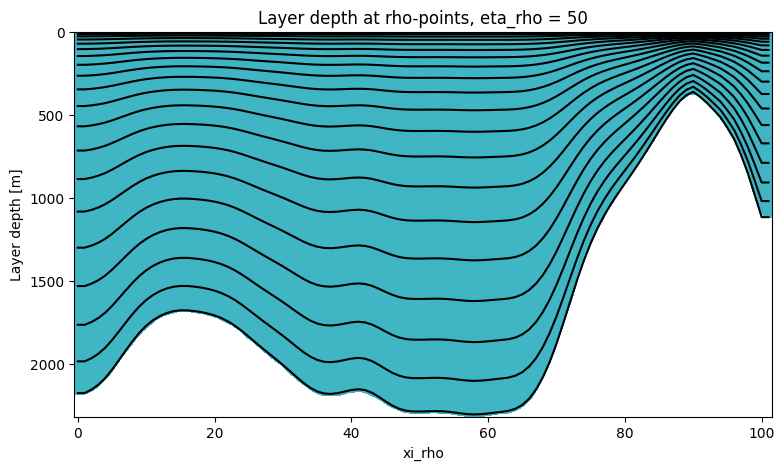

In [29]:
grid_with_small_critical_depth.plot_vertical_coordinate(eta=50)

When comparing the three plots above, we observe that 

* increasing `hc` results in a higher proportion of the upper ocean having nearly evenly spaced levels. It's important to note that despite setting `hc` to 1000m in the second plot, the evenly spaced levels do not extend all the way down to 1000m. However, in deeper ocean regions (visible in the left part of the plot), we approach this depth threshold more closely.
* reducing `hc` leads to a smaller proportion of the upper ocean having nearly evenly spaced levels.

#### Surface and bottom control parameters

The surface control parameter `theta_s` and bottom control parameter `theta_b` determine how much the vertical grid is stretched near the surface and bottom, respectively. Let's change these two parameters and see what happens.

In [30]:
grid_with_large_theta_s = Grid(
    **fixed_grid_parameters,
    theta_s=10.0,
    theta_b=control_grid.theta_b,
    hc=control_grid.hc
)

grid_with_small_theta_s = Grid(
    **fixed_grid_parameters,
    theta_s=2.0,
    theta_b=control_grid.theta_b,
    hc=control_grid.hc
)

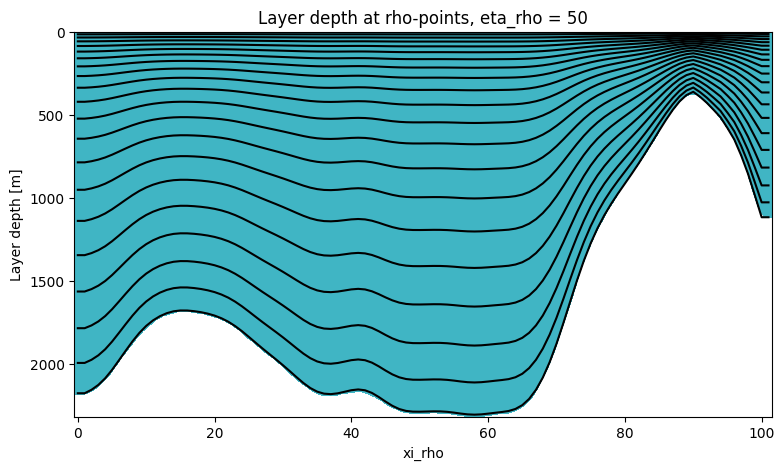

In [31]:
control_grid.plot_vertical_coordinate(eta=50)

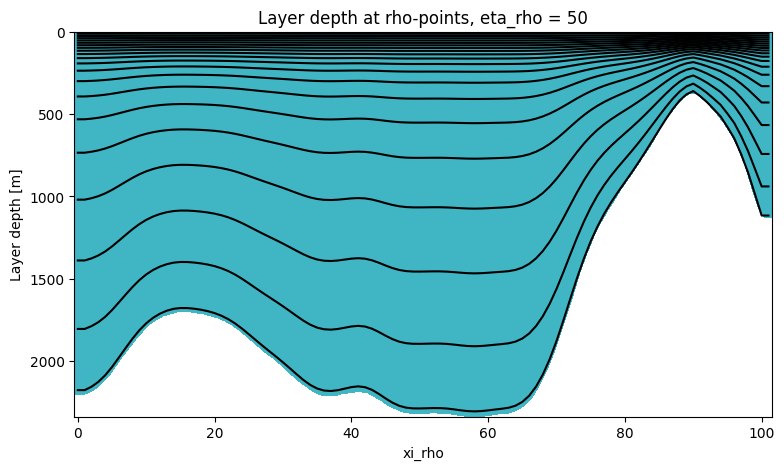

In [32]:
grid_with_large_theta_s.plot_vertical_coordinate(eta=50)

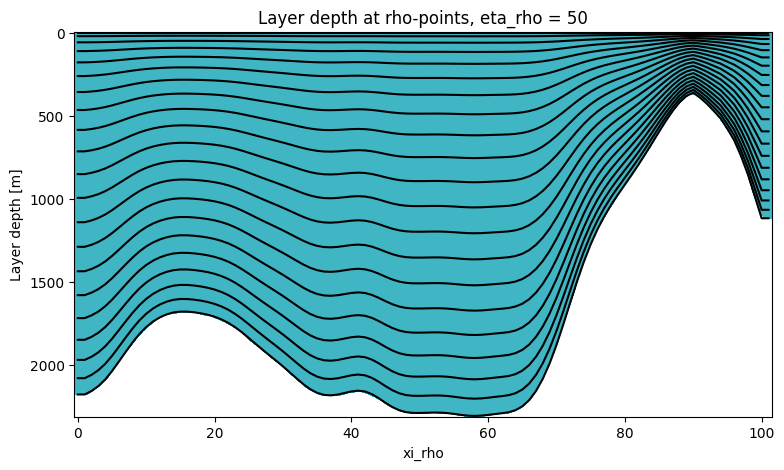

In [33]:
grid_with_small_theta_s.plot_vertical_coordinate(eta=50)

When comparing the three plots above, we can see that 

* increasing `theta_s` leads to a refinement of the vertical grid near the surface,
* reducing `theta_s` leads to coarsening of the vertical grid near the surface.

We can play a similar game with the bottom control parameter `theta_b`.

In [34]:
grid_with_large_theta_b = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=4.0,
    hc=control_grid.hc
)

grid_with_small_theta_b = Grid(
    **fixed_grid_parameters,
    theta_s=control_grid.theta_s,
    theta_b=0.5,
    hc=control_grid.hc
)

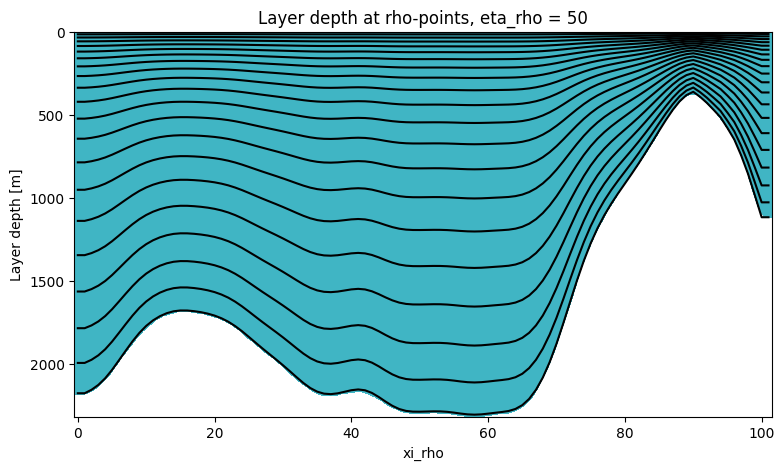

In [35]:
control_grid.plot_vertical_coordinate(eta=50)

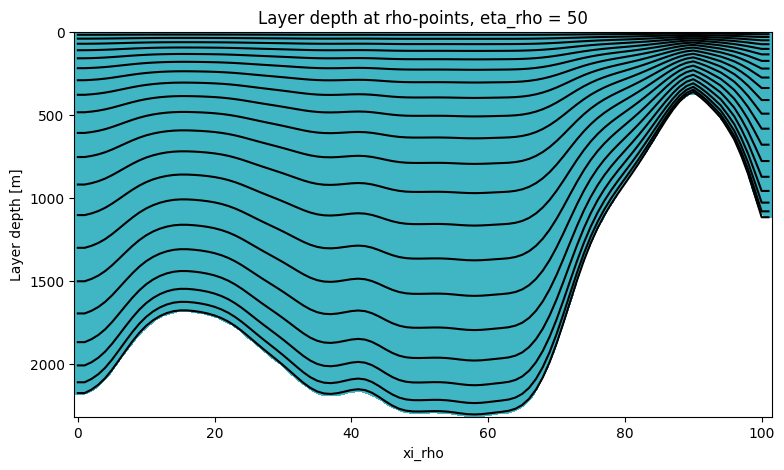

In [36]:
grid_with_large_theta_b.plot_vertical_coordinate(eta=50)

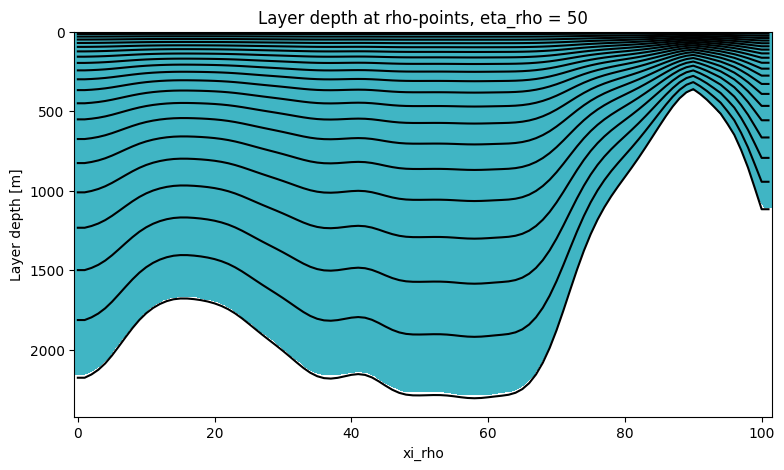

In [37]:
grid_with_small_theta_b.plot_vertical_coordinate(eta=50)

Again, comparing the three plots above, we can see that 

* increasing `theta_b` leads to a refinement of the vertical grid near the bottom,
* reducing `theta_b` leads to coarsening of the vertical grid near the bottom.

### Updating the vertical coordinate system

If you want to update the vertical coordinate system but would like to keep the same horizontal grid and topography, you can skip Steps I and II. 
This can be easily achieved using the `.update_vertical_coordinate` method. 

In [38]:
grid

Grid(nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-10, center_lat=61, rot=20, N=100, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=True, straddle=True)

In [39]:
grid.update_vertical_coordinate(N=10, theta_s=1.0, verbose=True)

INFO - === Preparing the vertical coordinate system using N = 10, theta_s = 1.0, theta_b = 2.0, hc = 300.0 ===
INFO - Total time: 0.003 seconds
INFO - ========================================================================================================


In the cell above, we regenerated the vertical coordinate system of our original grid, but this time only with 10 layers and `theta_s = 1.0`.

In [40]:
grid

Grid(nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-10, center_lat=61, rot=20, N=10, theta_s=1.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=True, straddle=True)

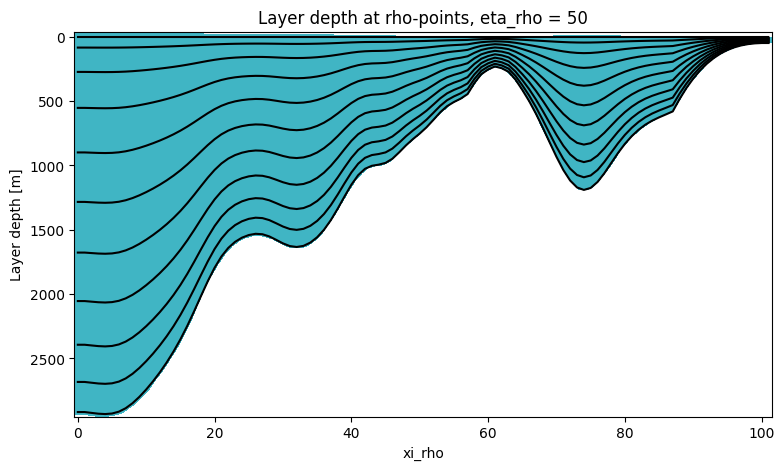

In [41]:
grid.plot_vertical_coordinate(eta=50)